This is the second part of the project: Forecast of NYC COVID-19 daily confirmed cases. Here I am going to train two models, the LSTM and 1-D CNN. Below is a quick review of the data we are going to use:

In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
covid = pd.read_csv("data/data-yqfdF.csv")
covid = covid[["DATE_OF_INTEREST","Cases"]]
covid = covid.rename(columns={"DATE_OF_INTEREST":"Date"})

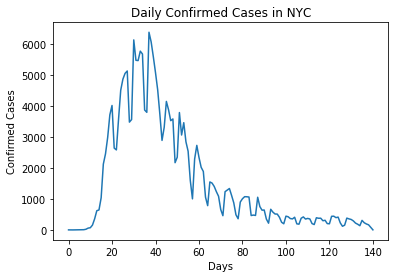

In [3]:
plt.title("Daily Confirmed Cases in NYC")
plt.ylabel('Confirmed Cases')
plt.xlabel('Days')
plt.plot(covid['Cases'])

In [4]:
covid19 = covid["Cases"].values.astype(float)

As what I did in part 1, I will use the first 120 observations as the training set, and the rest as the test set. Before I fit the data, I will also normalize the data into a (-1,1) scale.

In [100]:
train_data = covid19[:120]
test_data = covid19[120:]

In [101]:
#from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data= scaler.fit_transform(train_data .reshape(-1, 1))

In [102]:
# Convert data into a tensor
train_data = torch.FloatTensor(train_data).view(-1)

In [103]:
# Create a window size defining how far I am going to look at
train_window = 3

In [104]:
def convertSeq(data,tw):
    output = []
    L = len(data)
    for i in range(L-tw):
        train_seq = data[i:i+tw]
        train_label = data[i+tw]
        output.append((train_seq,train_label))
    return output

In [105]:
train = convertSeq(train_data,train_window)

# LSTM Train

In [108]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=20, output_size=1):
        super(LSTM,self).__init__()
        
        self.hidden_layer_size = hidden_layer_size
        
        self.lstm = nn.LSTM(input_size,hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                           torch.zeros(1,1,self.hidden_layer_size))
    
    
    
    def forward(self,input):
        #print(self.hidden)
        lstm_out, self.hidden = self.lstm(input.view(len(input),1,-1), self.hidden_cell)
        lstm_out, self.hidden = self.lstm(input.view(len(input),1,-1), self.hidden)
        lstm_out, self.hidden = self.lstm(input.view(len(input),1,-1), self.hidden)
        lstm_out, self.hidden = self.lstm(input.view(len(input),1,-1), self.hidden)
       
        predictions = self.linear(lstm_out.view(len(input), -1))
        
        return predictions[-1]

In [109]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [110]:
epochs = 150

for i in range(epochs):
    for seq, labels in train:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        
        y_pred = model(seq)
        

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

C:\Users\Yiling Yang\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 0.00000063
epoch:  26 loss: 0.00065609
epoch:  51 loss: 0.00087248
epoch:  76 loss: 0.00085113
epoch: 101 loss: 0.00097162
epoch: 126 loss: 0.00109513
epoch: 149 loss: 0.0007461299


# LSTM Test

In [111]:
future = 20
test_inputs = train_data[-3:].tolist()

In [112]:
model.eval()

for i in range(future):
    seq = torch.FloatTensor(test_inputs[-3:])
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_layer_size),
                    torch.zeros(1,1,model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [113]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[3:]).reshape(-1,1))

In [114]:
# MSE
x = np.arange(120,140).reshape(-1,1)
y_true = np.array(covid['Cases'])[120:140]
y_true = y_true.reshape(-1,1)
np.mean((y_true - actual_predictions)**2)

13356.341335025756

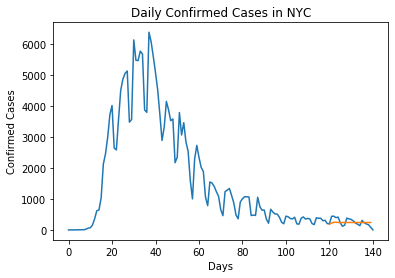

In [72]:
plt.title("Daily Confirmed Cases in NYC")
plt.ylabel('Confirmed Cases')
plt.xlabel('Days')
plt.plot(covid['Cases'])
plt.plot(x,actual_predictions)